In [6]:
## import Matpolt with PyQt4 Backend
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
caffe_root = 'crfasrnn/caffe-crfrnn/'
import sys
sys.path.insert(0, caffe_root + 'python')

In [10]:
import cPickle
import logging
import numpy as np
import pandas as pd
from PIL import Image as PILImage
#import Image
import cStringIO as StringIO
import caffe

from SimpleCV import *

In [12]:
# CRFasRNN Config
MODEL_FILE = "crfasrnn/python-scripts/TVG_CRFRNN_COCO_VOC.prototxt"
PRETRAINED = "crfasrnn/python-scripts/TVG_CRFRNN_COCO_VOC.caffemodel"

net = caffe.Segmenter(MODEL_FILE, PRETRAINED)

In [21]:
def scale_128x128(image_path, dest):
    scaled_image = Image(image_path).adaptiveScale((128, 128))
    scaled_image_path = dest + "128x128_" + os.path.basename(image_path)
    scaled_image.save(scaled_image_path)
    return scaled_image_path

def get_segmentation_position(image):
    width = image.shape[0]
    height = image.shape[1]
    maxDim = max(width, height)
    
    image = PILImage.fromarray(np.uint8(image))
    image = np.array(image)
    
    mean_vec = np.array([103.999, 116.779, 123.68], dtype=np.float32)
    reshaped_mean_vec = mean_vec.reshape(1, 1, 3)
    
    im = image[:,:,::-1]
    im = im - reshaped_mean_vec
    
    cur_h, cur_w, cur_c = im.shape
    pad_h = 500 - cur_h
    pad_w = 500 - cur_w
    im = np.pad(im, pad_width=((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)
    
    segmentation = net.predict([im])
    segmentation2 = segmentation[0:cur_h, 0:cur_w]
    
    return segmentation2

def white_background(image, segmentation):
    height = segmentation.shape[0]
    width = segmentation.shape[1]
    
    input_image = np.copy(image)

    for j in xrange(height):
        for k in xrange(width):
            if segmentation[j][k] == 0:
                input_image[j][k] = 255
    
    return input_image

def black_background(image, segmentation):
    height = segmentation.shape[0]
    width = segmentation.shape[1]
    
    input_image = np.copy(image)

    for j in xrange(height):
        for k in xrange(width):
            if segmentation[j][k] == 0:
                input_image[j][k] = 0
    
    return input_image

def show_image(image_array):
    image = PILImage.fromarray(np.uint8(image_array))
    plt.imshow(image)
    
def preprocessing(image_path, dest):
    scale_path = scale_128x128(image_path, dest)
    
    input_image = 255 * caffe.io.load_image(scale_path)
    segmentation = get_segmentation_position(input_image)
    whited_back_image = white_background(input_image, segmentation)
    blacked_back_image = black_background(input_image, segmentation)
    
    return whited_back_image

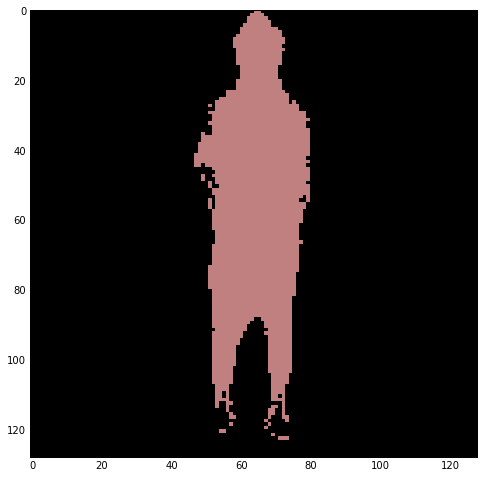

In [22]:
test = "test.jpg"
dest = "data/"
segmentation, white, black = preprocessing(test, dest)

In [ ]:
white = PILImage.fromarray(np.uint8(white))
white

In [ ]:
black = PILImage.fromarray(np.uint8(black))
black

In [20]:
pallete = [0,0,0,
            128,0,0,
            0,128,0,
            128,128,0,
            0,0,128,
            128,0,128,
            0,128,128,
            128,128,128,
            64,0,0,
            192,0,0,
            64,128,0,
            192,128,0,
            64,0,128,
            192,0,128,
            64,128,128,
            192,128,128,
            0,64,0,
            128,64,0,
            0,192,0,
            128,192,0,
            0,64,128,
            128,64,128,
            0,192,128,
            128,192,128,
            64,64,0,
            192,64,0,
            64,192,0,
            192,192,0]

segmentation = PILImage.fromarray(segmentation)
segmentation.putpalette(pallete)

TypeError: expected string or buffer